<a href="https://colab.research.google.com/github/HilkarSoberanes/MachineLearning/blob/main/MNIST_CVAE_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Variational Autoencoder Implementation for Denoising the dataset MNIST


In this notebook we train a Variational Autoencoder (VAE) on the a noisy versión of the MNIST dataset. The VAE is a type of autoencoder probabilistic. So instead of leatting our neural network learn an arbitrary function, we are learning the parameters of a probability distribution modeling our data.   

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive # Google Drive package 
from PIL import Image
drive.mount("/content/drive")

Mounted at /content/drive


### Define the architecture of our encoder and decoder networks 

In this VAE example, we use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively.  Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation $x$ and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 


### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation $x$. Model the latent distribution prior $p(z)$ as a unit Gaussian.


### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use four convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by five convolution transpose layers (a.k.a. deconvolutional layers in some contexts). 

## Create a sampling layer

In [2]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(16, 5, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.Conv2D(32, 5, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(64, 5, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 5, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 16)   416         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 32)   12832       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   51264       ['conv2d_1[0][0]']               
                                                                                            

## Build the decoder

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 5, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 5, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 5, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(16, 5, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 5, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 6272)              18816     
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      409728    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       204864    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 32)       5123

## Define the VAE as a `Model` with a custom `train_step`

In [5]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Load MNIST Dataset

Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. 

In [6]:
(x_train_images, _), (x_test_images, _) = keras.datasets.mnist.load_data()
x_train_images = np.expand_dims(x_train_images, -1).astype("float32")/255
x_test_images = np.expand_dims(x_test_images, -1).astype("float32")/255

11490434/11490434 [==============================] - 2s 0us/step


### Adding random noie to the images and plotting them

In [7]:
noise_factor = 0.4
x_train_noisy = x_train_images + noise_factor * tf.random.normal(shape=x_train_images.shape) 
x_test_noisy = x_test_images + noise_factor * tf.random.normal(shape=x_test_images.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)



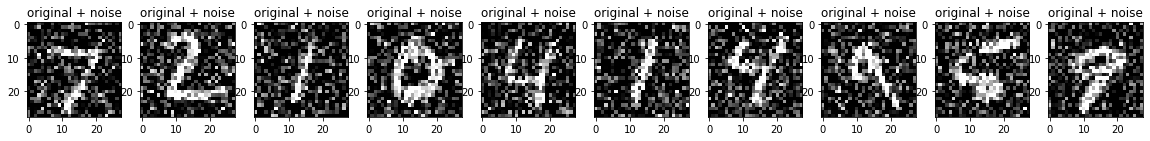

In [21]:
n = 10

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

## Train the VAE

In [41]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-4))


vae.fit(x_train_noisy, x_train_images, epochs=40, batch_size=128)

Epoch 1/10
469/469 [==============================] - 21s 43ms/step - loss: 150.0484 - reconstruction_loss: 143.6484 - kl_loss: 6.2831
Epoch 2/10
469/469 [==============================] - 21s 44ms/step - loss: 149.4842 - reconstruction_loss: 143.3874 - kl_loss: 6.2886
Epoch 3/10
469/469 [==============================] - 20s 43ms/step - loss: 149.3461 - reconstruction_loss: 143.2119 - kl_loss: 6.3187
Epoch 4/10
469/469 [==============================] - 20s 43ms/step - loss: 149.0672 - reconstruction_loss: 142.8555 - kl_loss: 6.3224
Epoch 5/10
469/469 [==============================] - 20s 43ms/step - loss: 148.7146 - reconstruction_loss: 142.6535 - kl_loss: 6.3555
Epoch 6/10
469/469 [==============================] - 20s 43ms/step - loss: 148.4103 - reconstruction_loss: 142.5466 - kl_loss: 6.3483
Epoch 7/10
469/469 [==============================] - 20s 43ms/step - loss: 148.6986 - reconstruction_loss: 142.2363 - kl_loss: 6.3936
Epoch 8/10
469/469 [==============================] - 2

## Display a grid of sampled digits

This will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space.

1/1 [==============================] - 0s 14ms/step


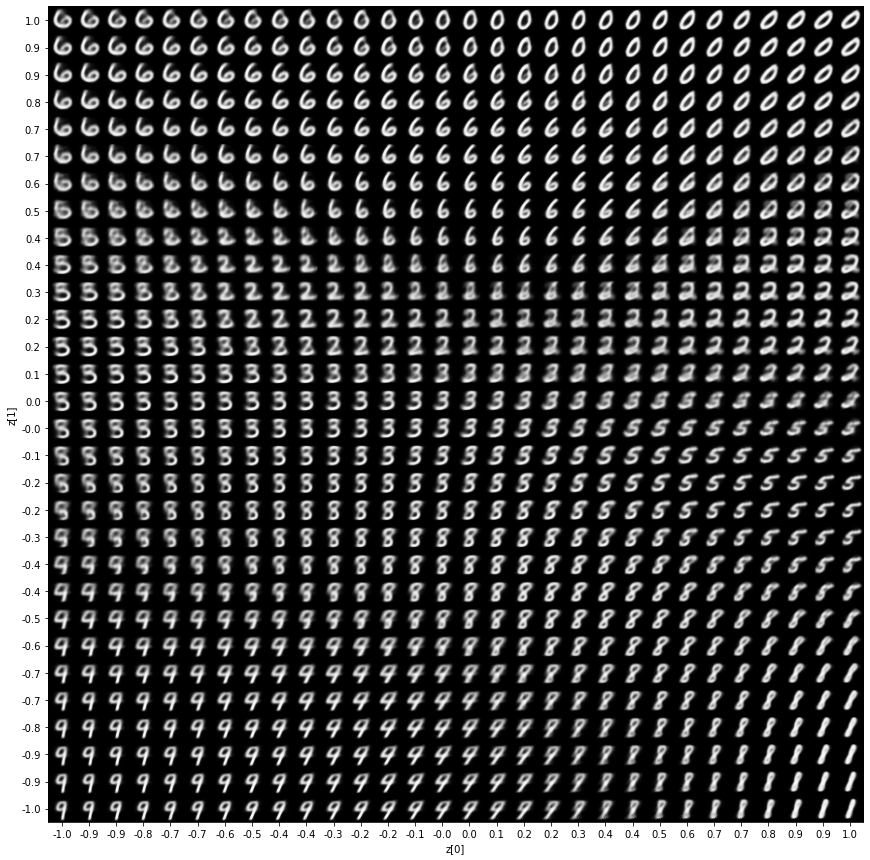

In [42]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

## Display how the latent space clusters different digit classes

1875/1875 [==============================] - 4s 2ms/step


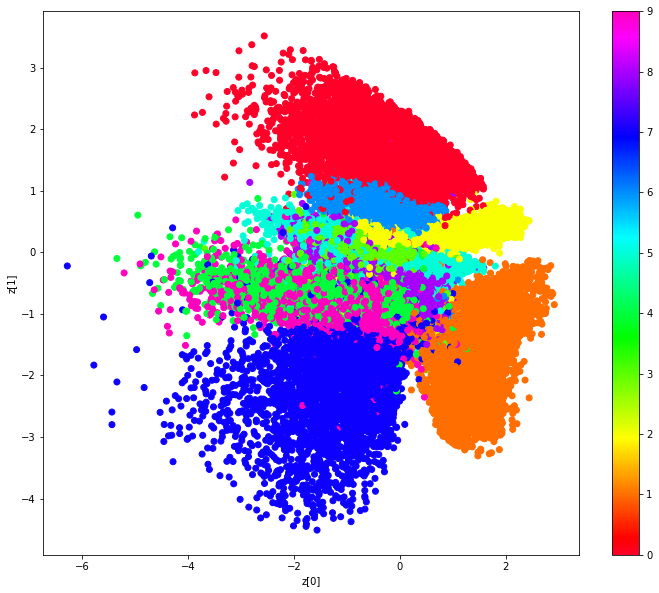

In [43]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='gist_rainbow')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

### Use CVAE model to predict test noisy images 

In [44]:
#x_test_noisy = np.expand_dims(x_test_noisy, -1)
z_mean, z_log_var, z =  vae.encoder.predict(x_test_noisy)
reconstruction = vae.decoder.predict(z)

313/313 [==============================] - 1s 3ms/step


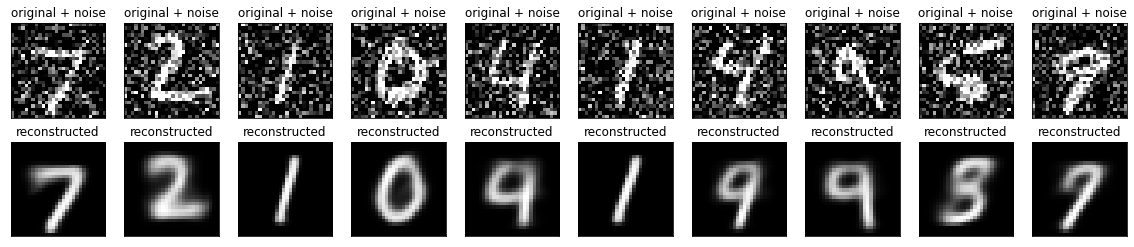

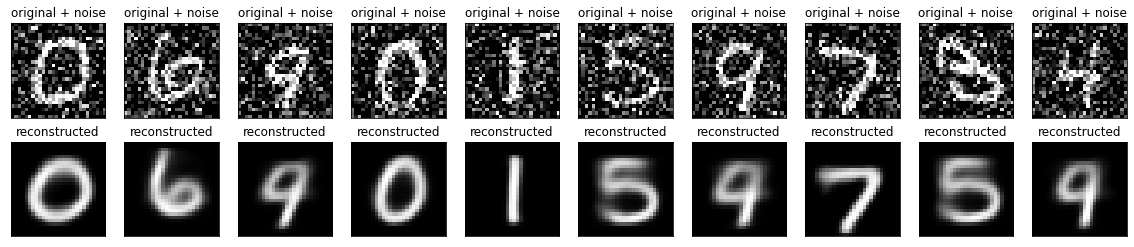

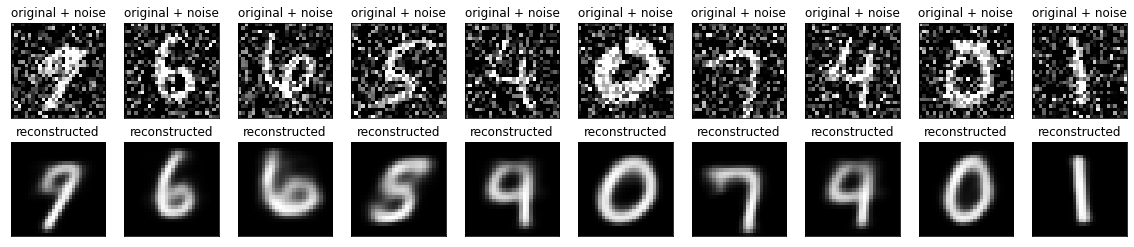

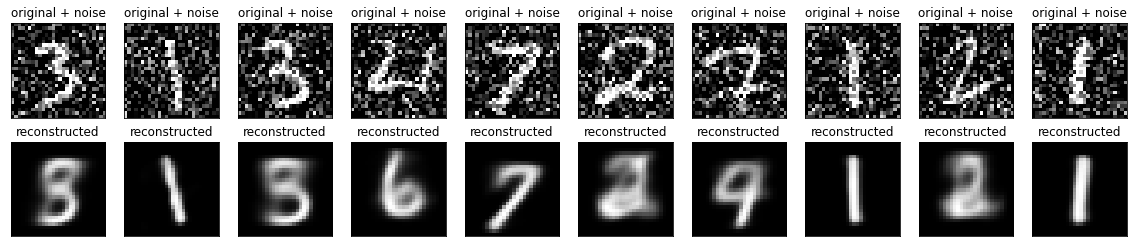

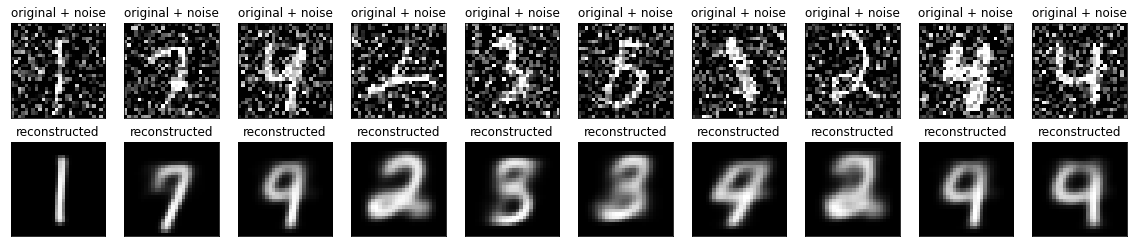

In [45]:
n = 10

for j in range(5):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i+j*10, :, :, 0])
    plt.title("original + noise")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction[i+j*10, :, :,0])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

### Use CVAE model to predict test images 

In [46]:
#x_test_images = np.expand_dims(x_test_images, -1)
z_mean, z_log_var, z =  vae.encoder.predict(x_test_images)
reconstruction = vae.decoder.predict(z)

313/313 [==============================] - 1s 3ms/step


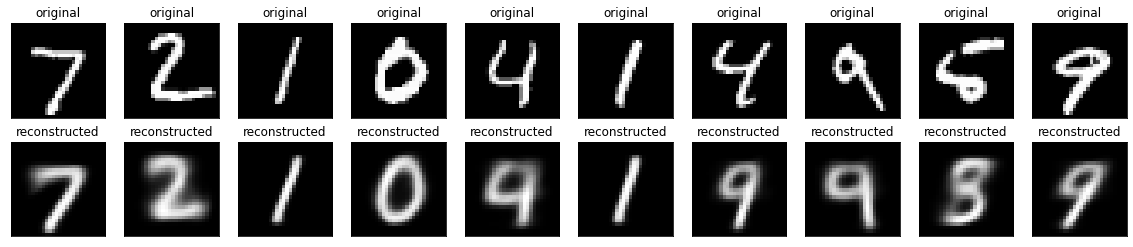

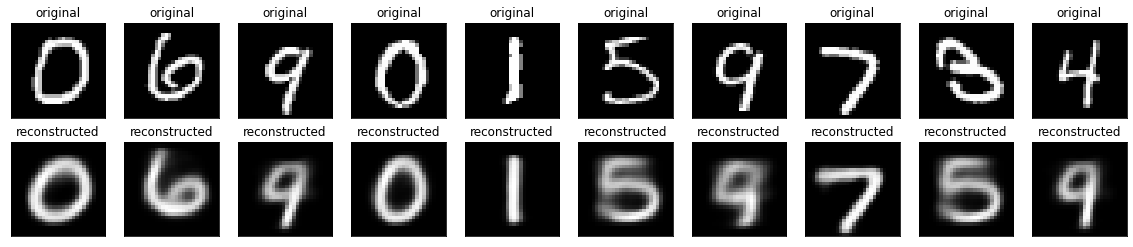

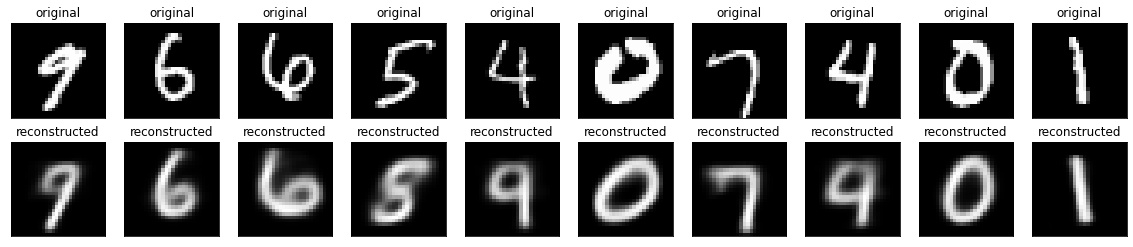

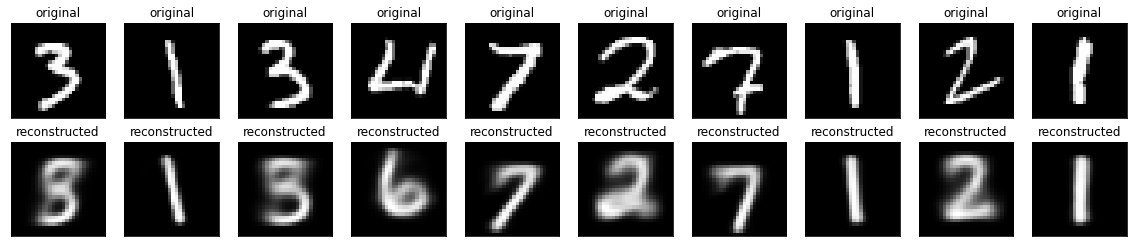

In [47]:
n = 10

for j in range(4):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_images[i+j*10, :, :, 0])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction[i+j*10, :, :,0])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

### Use CVAE model to predict drawn digits

In [48]:
test_images_2 = np.array([np.array(Image.open('/content/drive/My Drive/MachineLearning/MNIST/%1i_%1i.png'%(i,j)).resize((28,28)))[:,:,:1]/255 for i in range(0,10) for j in range(1,11)])

In [49]:
test_images_2 = tf.random.shuffle(test_images_2, seed=None, name=None)

In [50]:
test_images_2.shape

TensorShape([100, 28, 28, 1])

In [51]:
#test_images_2 = np.expand_dims(test_images_2, -1)
z_mean, z_log_var, z =  vae.encoder.predict(test_images_2)
reconstruction = vae.decoder.predict(z)

4/4 [==============================] - 0s 5ms/step


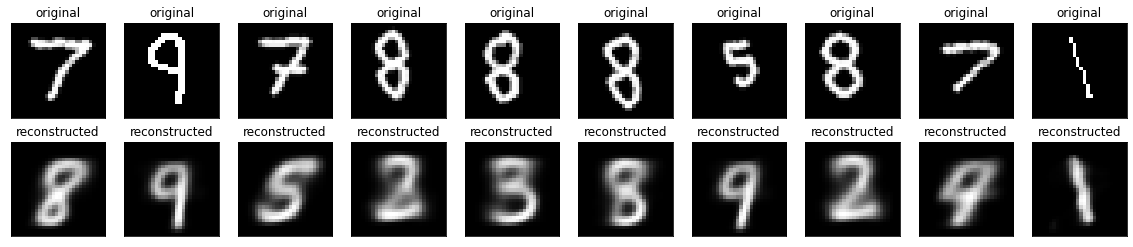

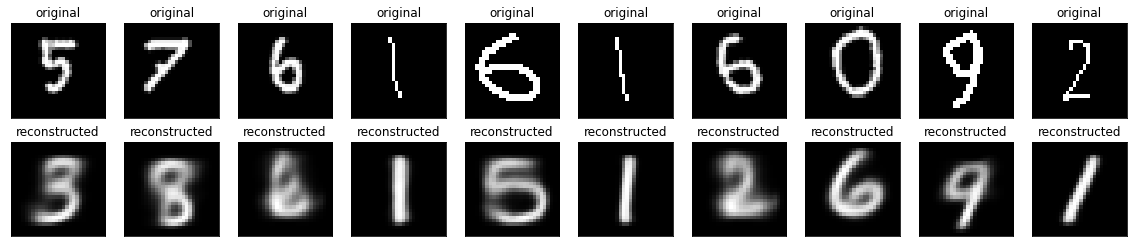

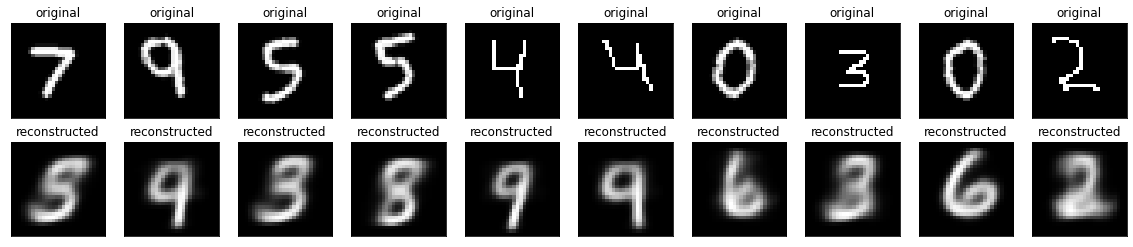

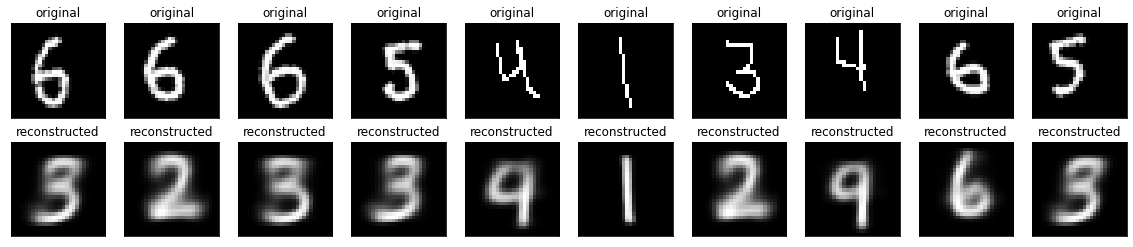

In [52]:
n = 10

for j in range(4):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images_2[i+j*10, :, :, 0])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction[i+j*10, :, :,0])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()